<a href="https://colab.research.google.com/github/SheidaTalei/FinalProject/blob/main/SheidaTalei_BERT_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [ ]:
# !pip install --target=$nb_path transformers

  Using cached https://files.pythonhosted.org/packages/99/84/7bc03215279f603125d844bf81c3fb3f2d50fe8e511546eb4897e4be2067/transformers-4.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/1c/e789a8b12e28be5bc1ce2156cf87cb522b379be9cadc7ad8091a4cc107c4/tokenizers-0.9.4-cp36-cp36m-manylinux2010_x86_64.whl
Processing /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45/sacremoses-0.0.43-cp36-none-any.whl


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import regex
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import re
import string
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
# %run SheidaTalei_Preprocessing_FinalProject.ipynb
# !pip install transformers

     |████████████████████████████████| 1.3MB 15.9MB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 
     |████████████████████████████████| 890kB 57.8MB/s 
     |████████████████████████████████| 1.1MB 56.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ff8266238d52b97c879e5fe30958852c93034afd51cfe5d0d08a665004e0875b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#------------------------------------------Empty Rows Removal----------------------------------------------------------------
# This function Will: 1- Remove all empty rows from csv file 2- Save data to the same csv
def removeEmptyRows(fileName):
    df = pd.read_csv(fileName, encoding='utf-8-sig')
    df = df.dropna(subset=['text'], how='all', axis=0) 
    df.to_csv(fileName, header=True, encoding='utf-8-sig',  index=False)
    
    return df

In [ ]:
X_and_Y = removeEmptyRows ('/content/drive/MyDrive/Final/Prepared_train_Data_test#1.csv')
Y_train= X_and_Y.Label
X_train = X_and_Y.text

In [ ]:
X_and_Y_test = removeEmptyRows('/content/drive/MyDrive/Final/Prepared_test_Data_test#1.csv')
Y_test= X_and_Y_test.Label
X_test = X_and_Y_test.text

In [ ]:
#source:
#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
#https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
#https://sci2lab.github.io/ml_tutorial/bert_farsi_sentiment/

In [ ]:
#We need to transform our data into a format BERT understands. 
# data is a dataFrame
def convert_data_into_input_example(data):
    """ Covert the list of examples into a list of `InputExample` objects that is suitable
        for BERT model."""
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid= None,
            text_a= data.iloc[i][ 'text'], #  is the text we want to classify
            text_b= None,
            label= data.iloc[i][ 'Label'] #is the label of our example, i.e. 1 or 0.
        )
        input_examples.append(example)
    return input_examples

In [ ]:
train_input_examples = convert_data_into_input_example(X_and_Y)
val_input_examples = convert_data_into_input_example(X_and_Y_test)

In [ ]:
train_input_examples[0]

InputExample(guid=None, text_a='بهائیت دین', text_b=None, label=1.0)

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

# text = 'I liked that book very much!'
# tokenized_text = tokenizer.tokenize(text)
# print(tokenized_text)
# text_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
# print('text ids:', text_ids)
# text_ids_with_special_tokens = tokenizer.build_inputs_with_special_tokens(text_ids)
# print('text ids with special tokens: ', text_ids_with_special_tokens)

In [ ]:
#Tokenization
label_list = [0.0, 1.0]
MAX_SEQ_LENGTH = 150
bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)
bert_val_dataset = glue_convert_examples_to_features(examples=val_input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)

# for i in range(3):
# #     print('Example: {}'.format(bert_train_dataset[i]))
#     print('Example: {')
#     print(' Input_ids: {}'.format(bert_train_dataset[i].input_ids))
#     print(' attention_mask: {}'.format(bert_train_dataset[i].attention_mask))
#     print(' token_type_ids: {}'.format(bert_train_dataset[i].token_type_ids))
#     print(' label: {}'.format(bert_train_dataset[i].label))
#     print('}')

/content/notebooks/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/content/notebooks/transformers/data/processors/glue.py:175: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [ ]:
#for myself
ex = bert_train_dataset[0]
in_ids = ex.input_ids
decoded_sentence = tokenizer.decode(in_ids, skip_special_tokens=True)
print(decoded_sentence)

بهائیت دین


In [ ]:
# import os
# checkpoint_path = "/content/drive/MyDrive/Final/Bert.ckpt"
# model = createLstmModel()
# model.load_weights(checkpoint_path)

In [ ]:
#Defining the Hyperparameters
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 2)

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric_accuracy , tf.keras.metrics.AUC()])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#, tf.keras.metrics.AUC()
# model.add(tf.keras.layers.Dense(nb_classes, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss, metrics=[ metric_accuracy])

In [ ]:
#training the model
# model.fit(bert_train_dataset, validation_data=bert_val_dataset, epochs=3)
def my_solution(bdset):
    """ Create a list of input tensors required to be in the first argument of the
        model call function for training. e.g. `model([input_ids, attention_mask, token_type_ids])`.
    """
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return ([input_ids, attention_mask, token_type_ids], label)
#Create a list of input tensors required to be in the first argument of the model call function for training. e.g.
# model([input_ids, attention_mask, token_type_ids]).

In [ ]:
# Convert a training example into the Bert compatible format.
def example_to_features(input_ids, attention_masks, token_type_ids, y):
    """ Convert a training example into the Bert compatible format."""
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids},y

In [ ]:
#source: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=IFPuhwntH8VH
import os
checkpoint_path = "/content/drive/MyDrive/Final/Bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
x_train, y_train = my_solution(bert_train_dataset)
x_val, y_val = my_solution(bert_val_dataset)

In [ ]:
#This part helps for handeling imbalanced data
count_0 = 0
count_1 = 0

for i in y_train:
    if (i==0):
        count_0 = count_0+1
    else:
        count_1 = count_1 + 1

In [ ]:
p = count_0 / (count_0 + count_1)

In [ ]:
print(p)

0.5647265429001506


In [ ]:


print('x_train shape: {}'.format(x_train[0].shape))
print('x_val shape: {}'.format(x_val[0].shape))

train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)
print(type (train_ds))
print('Format of model input examples: {} '.format(train_ds.take(1)))

EPOCHS = 5 # 1000

# history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS , batch_size = 150)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,  batch_size = 150,callbacks=[cp_callback], class_weight = {0: 1/p, 1: 1/(1-p)} ) 

x_train shape: (3986, 150)
x_val shape: (1000, 150)
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Format of model input examples: <TakeDataset shapes: ({input_ids: (None, 150), attention_mask: (None, 150), token_type_ids: (None, 150)}, (None, 1)), types: ({input_ids: tf.int64, attention_mask: tf.int64, token_type_ids: tf.int64}, tf.int64)> 
Epoch 1/5
125/125 [==============================] - 133s 1s/step - loss: 0.0824 - accuracy: 0.9882 - val_loss: 0.3937 - val_accuracy: 0.9160

Epoch 00001: saving model to /content/drive/MyDrive/Final/Bert.ckpt
Epoch 2/5
125/125 [==============================] - 133s 1s/step - loss: 0.0595 - accuracy: 0.9875 - val_loss: 0.3355 - val_accuracy: 0.9260

Epoch 00002: saving model to /content/drive/MyDrive/Final/Bert.ckpt
Epoch 3/5
125/125 [==============================] - 134s 1s/step - loss: 0.0597 - accuracy: 0.9892 - val_loss: 0.5058 - val_accuracy: 0.9100

Epoch 00003: saving model to /content/drive/MyDrive/Final/Bert.ckpt
Epoch 4/

In [ ]:
#Loading the model
# import os
# checkpoint_path = "/content/drive/MyDrive/Final/Bert.ckpt"

# model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 2)
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


# model.compile(optimizer=optimizer, loss=loss, metrics=[ metric_accuracy])
# model.load_weights(checkpoint_path)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

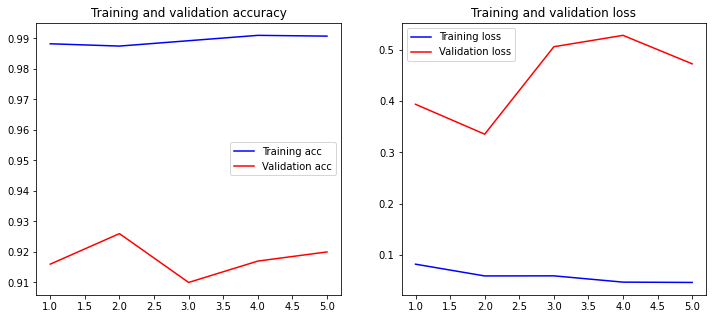

In [ ]:
# model.fit(bert_train_dataset, validation_data=bert_val_dataset, epochs=3)
plot_history(history)

In [ ]:
predictions = model.predict(val_ds)
print(predictions[0].shape)
print()
predictions_classes = np.argmax(predictions[0], axis = 1)
for i in range(10):
    print('text: {}\n, actual label: {}, predicted label: {}'.format(X_and_Y_test.iloc[i]['text'], val_input_examples[i].label, predictions_classes[i]))

(1000, 2)

text: تفهیم وضعیت شهروند اتسا گزارش اتهام اخرین اوین بیمار زندان احمدائی تداوم
, actual label: 0.0, predicted label: 0
text: وابستگی سیاست لیبرال سایت میدانید مبری ی بهائیت تکرار خدا تورم خود صرافیها بعد پشت بنده مثقال زد#زن سر بد وجود بهایی حرف روحانی میفهمی دوگروه بهار
, actual label: 1.0, predicted label: 1
text: انجمن درمورد ایا حسین امام مراسم داشت#دار دانست#دان هشدار دوست بهائیان پزشک ایران گروهی اجرا توطئه
, actual label: 0.0, predicted label: 0
text: خبرنگارا ناراحت اصلاح طلبا از هستن پرچم بشر چیه تعریف حقوق شهروند فرق اسم میگن نمیکنیم دفاع برانداز همیشگی سکوت حکم کننده
, actual label: 0.0, predicted label: 0
text: صدا مولود سیما ان شک بهائی
, actual label: 1.0, predicted label: 1
text: رتبه تو شرکت رشته بخاطر قبول سراسر میتونست سراوان هایی محرومیت ای کشور کنکور دوست زدن ریاضی براش
, actual label: 0.0, predicted label: 0
text: کرد#کن دلیل نیابت مهدی تنفر استوار بخوام علما بد حکومت موعود مشروعیت اساس ائین ساده توضیح خیلی امدن شیعه بهائی
, actual label: 0.0, predicted 

In [ ]:
#newly added
predictions = model.predict(val_ds)
predictions_classes = np.argmax(predictions[0], axis = 1)
# print(predictions_classes)
print ('Accuracy for BERT: ',accuracy_score(y_val, predictions_classes))
print('F1-score for BERT: ', f1_score(y_val, predictions_classes))
print('roc_auc_score for BERT: ', roc_auc_score(y_val, predictions_classes))

Accuracy for BERT:  0.92
F1-score for BERT:  0.9136069114470842
roc_auc_score for BERT:  0.9207984675874584


In [ ]:
#Convert the test examples into Bert compatible format.
def example_to_features_predict(input_ids, attention_masks, token_type_ids):
    """
        Convert the test examples into Bert compatible format.
    """
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}


In [ ]:

def get_prediction(in_sentences):
    """
        Prepare the test comments and return the predictions.
    """
    label_list = [0.0, 1.0]
    input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0.0) for x in in_sentences] # here, "" is just a dummy label
    predict_input_fn = glue_convert_examples_to_features(examples=input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)
    x_test_input, y_test_input = my_solution(predict_input_fn)
    test_ds   = tf.data.Dataset.from_tensor_slices((x_test_input[0], x_test_input[1], x_test_input[2])).map(example_to_features_predict).batch(32)

    predictions = model.predict(test_ds)
    #   print('predictions:', predictions[0].shape)
    predictions_classes = np.argmax(predictions[0], axis = 1)
    return [(sentence, prediction) for sentence, prediction in zip(in_sentences, predictions_classes)]

In [ ]:
#Prepare the test comments and return the predictions

pred_sentences = []
i = 0
while(i<20):
  for tweet in X_and_Y_test.text:
    pred_sentences.append(tweet)
    i +=1
predictions = get_prediction(pred_sentences)
for p in predictions:
    print(p)

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:175: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Streaming output truncated to the last 5000 lines.
('نمایشگاه حقوق بشر خارجه وزارت نقض امریکا سخنران ایران', 0)
('محکوم سه سالگی بازداشت شده بود زن… روز اعدام زندان شنبه مهرماه سیاسی', 0)
('مرد زن ریش اراستگی چسه کرد#کن اصلاح مو اقایون فرمی… جالبتره حالا', 0)
('دفن ایا سرباز ترین روستا میدانستید پربازدید نقاط ازادی ایران محل', 0)
('مربوط ظریف باید معرف مسئولای براشون جناب کشور مهم چینیا تجار میزدن مسائل اینجا نمیکنید رسید#رس امریکا مشنگ موقع روابط بال سفیر دیگه', 0)
('نوبت نشه فردا کثافت منه کاشت#کار جلو کدو می تونست دختر', 0)
('دردناک اشتیاق ازادی بردگی نداشته باشد برده', 0)
('شباهت علی نژاد ای مسیح معصومه مرور کرد#کن تاریخچه مزدور صاد… زیاد معروف قم مجاهدین', 0)
('باور اعمالشون همزمان تک چرت بگیره طرف برسن کثافتا اسید سزا دست دختره بنزین خانواده کرد#کن شوکر 😐 اینقدر چقدر بره چاقو جر تو نمیتونم راست اخه چندتا خونه بتونه دل', 0)
('بچه ستاره رفیق به ماه قدیم غریب میرسونن😉😅👌💙 فکر کن مشهد یهو بود#باش یاد سلام بیاد زنگ بزنی', 0)
('دختره مدیر بیشرف تجاوز مرد', 0)
('بیشتر دلار بدونید شاه شهی

In [ ]:
print("Evaluating the BERT model")
model.evaluate(val_ds)

Evaluating the BERT model
119/119 [==============================] - 67s 565ms/step - loss: 0.5368 - accuracy: 0.7744


[0.5368150472640991, 0.7743983268737793]